In [1]:
# First, install the kagglehub package
!pip install kagglehub

# Now import and use the module
import kagglehub

# Download latest version
path = kagglehub.dataset_download("uraninjo/augmented-alzheimer-mri-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'augmented-alzheimer-mri-dataset' dataset.
Path to dataset files: /kaggle/input/augmented-alzheimer-mri-dataset


In [2]:
# =============================================
# 🔹 Step 2: Install Required Libraries
# =============================================
!pip install numpy matplotlib opencv-python tensorflow scikit-learn tqdm

import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.applications import ConvNeXtBase
from tensorflow.keras.applications.convnext import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# =============================================
# 🔹 Step 3: Define Dataset Paths
# =============================================
train_dir = "/content/drive/MyDrive/AugmentedAlzheimerDataset"  # Training dataset folder
test_dir = "/content/drive/MyDrive/OriginalDataset"    # Testing dataset folder
img_size = (128, 128)  # Image size reduced for faster processing

In [3]:
# =============================================
# 🔹 Step 4: Function to Load and Preprocess Images
# =============================================
def load_images_from_folder(folder):
    """Load images and labels from a folder with subfolders as classes."""
    images, labels = [], []

    for class_name in os.listdir(folder):
        class_path = os.path.join(folder, class_name)
        if os.path.isdir(class_path):
            for file in os.listdir(class_path):
                if file.endswith(('.jpg', '.jpeg', '.png')):
                    img_path = os.path.join(class_path, file)

                    # Load and resize image
                    img = cv2.imread(img_path)
                    if img is not None:
                        img = cv2.resize(img, img_size)
                        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                        images.append(img)
                        labels.append(class_name)

    print(f"✅ Loaded {len(images)} images from {folder}")
    return np.array(images), np.array(labels)



In [ ]:
# =============================================
# 🔹 Step 5: Load and Preprocess Train and Test Data
# =============================================

# Define the correct paths to your dataset
# Replace these with the actual paths where your data is stored
train_dir = os.path.join(path, "AugmentedAlzheimerDataset")  # Training dataset folder
test_dir = os.path.join(path, "OriginalDataset")    # Testing dataset folder

# Load Train Images
X_train, y_train = load_images_from_folder(train_dir)
X_train = preprocess_input(X_train)

# Load Test Images
X_test, y_test = load_images_from_folder(test_dir)
X_test = preprocess_input(X_test)

# Encode Labels
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

print(f"✅ Train Data: {X_train.shape}, Labels: {y_train_encoded.shape}")
print(f"✅ Test Data: {X_test.shape}, Labels: {y_test_encoded.shape}")

✅ Loaded 33984 images from /kaggle/input/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset
✅ Loaded 6400 images from /kaggle/input/augmented-alzheimer-mri-dataset/OriginalDataset
✅ Train Data: (33984, 128, 128, 3), Labels: (33984,)
✅ Test Data: (6400, 128, 128, 3), Labels: (6400,)


In [ ]:
# =============================================
# 🔹 Step 6: Create ConvNeXtBase Model
# =============================================
# Use ConvNeXtBase for feature extraction
base_model = ConvNeXtBase(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False  # Freeze the base model

# Build the model
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(len(le.classes_), activation='softmax')  # Dynamic classes
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# =============================================
# 🔹 Step 7: Add Early Stopping and LR Scheduler
# =============================================
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)



350926856/350926856 ━━━━━━━━━━━━━━━━━━━━ 16s 0us/step


In [ ]:
# =============================================
# 🔹 Step 8: Train the Model
# =============================================
epochs = 30
batch_size = 32

history = model.fit(
    X_train, y_train_encoded,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test, y_test_encoded),
    callbacks=[early_stopping, lr_scheduler]
)

# =============================================
# 🔹 Step 9: Evaluate on Test Set
# =============================================
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Calculate Accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred)
print(f"\n✅ Test Accuracy: {test_accuracy:.4f}")

# Confusion Matrix and Classification Report
print("\n📊 Confusion Matrix:")
print(confusion_matrix(y_test_encoded, y_pred))

print("\n📊 Classification Report:")
print(classification_report(y_test_encoded, y_pred, target_names=le.classes_))

Epoch 1/30
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 180s 149ms/step - accuracy: 0.5143 - loss: 1.0769 - val_accuracy: 0.5648 - val_loss: 0.8859 - learning_rate: 0.0010
Epoch 2/30
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 153s 144ms/step - accuracy: 0.6364 - loss: 0.7827 - val_accuracy: 0.5603 - val_loss: 0.8701 - learning_rate: 0.0010
Epoch 3/30
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 153s 144ms/step - accuracy: 0.6591 - loss: 0.7378 - val_accuracy: 0.5989 - val_loss: 0.8057 - learning_rate: 0.0010
Epoch 4/30
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 153s 144ms/step - accuracy: 0.6725 - loss: 0.7074 - val_accuracy: 0.6253 - val_loss: 0.7457 - learning_rate: 0.0010
Epoch 5/30
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 153s 144ms/step - accuracy: 0.6885 - loss: 0.6785 - val_accuracy: 0.6733 - val_loss: 0.7122 - learning_rate: 0.0010
Epoch 6/30
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 153s 144ms/step - accuracy: 0.7016 - loss: 0.6517 - val_accuracy: 0.6608 - val_loss: 0.7062 - learning_rate: 0.0010
Epoch 7/30
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 153s 144ms

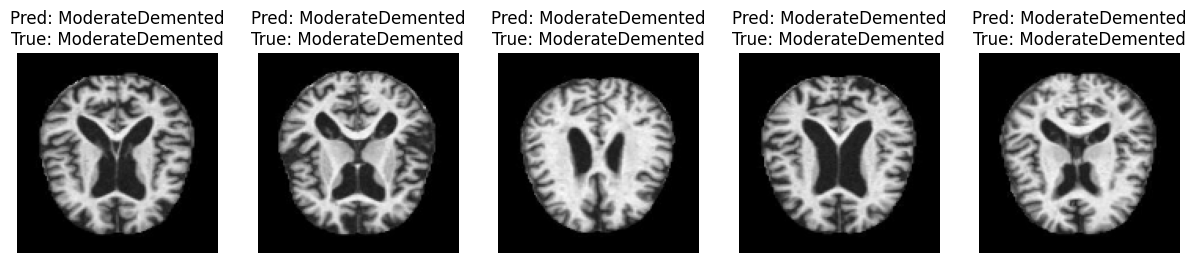

In [ ]:
# =============================================
# 🔹 Step 10: Display Sample Predictions
# =============================================
num_samples = 5
fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))

for i in range(num_samples):
    axes[i].imshow(X_test[i].astype("uint8"))
    axes[i].set_title(f"Pred: {le.inverse_transform([y_pred[i]])[0]}\nTrue: {y_test[i]}")
    axes[i].axis('off')

plt.show()



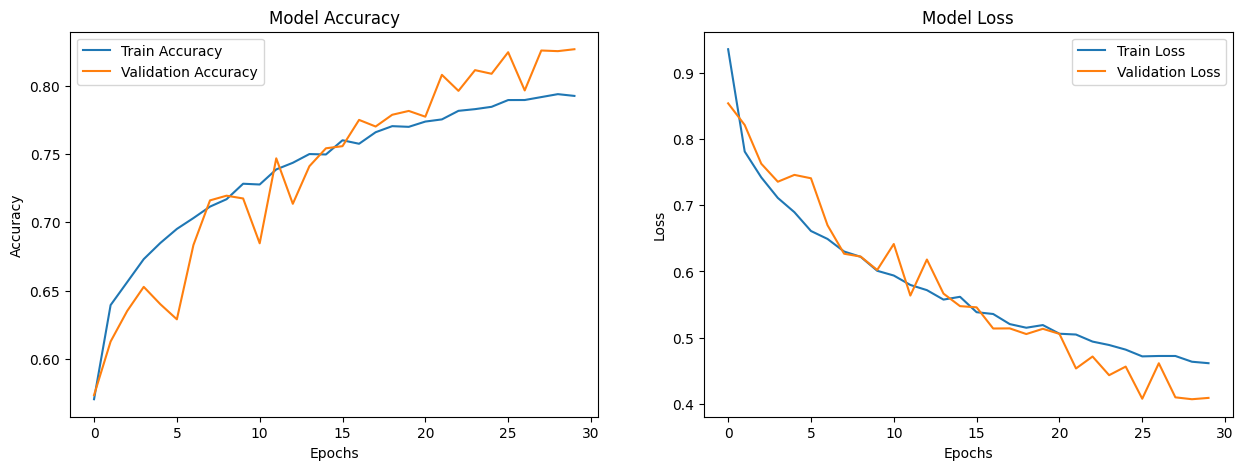

In [ ]:
# =============================================
# 🔹 Step 11: Plot Accuracy and Loss Graphs
# =============================================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot Accuracy
ax1.plot(history.history['accuracy'], label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot Loss
ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

plt.show()

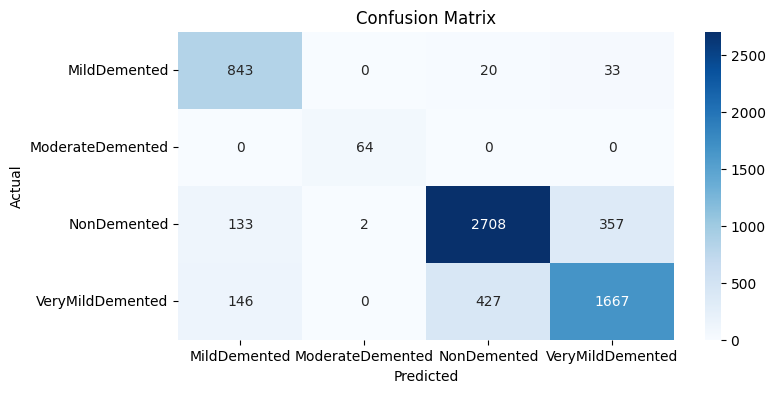

In [ ]:
# =============================================
# 🔹 Step 12: Confusion Matrix Visualization
# =============================================
import seaborn as sns

fig, ax = plt.subplots(figsize=(8, 4))
cm = confusion_matrix(y_test_encoded, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
